In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


# Data

### preprocces method


In [3]:
def process_data(file_path, per_cluster=500):
    # Read the data
    data = pd.read_csv(file_path, header=None)
    
    if per_cluster:
        # Filter the data to keep only the specified number of entries per cluster
        filtered_data = data.groupby(0).apply(lambda x: x.head(per_cluster)).reset_index(drop=True)
    else:
        # If per_cluster is not specified, use all the data
        filtered_data = data
    
    # Extract feature columns and true labels
    X = filtered_data.iloc[:, 3:].values  # Feature columns
    true_labels = filtered_data.iloc[:, 0].values  # True labels (BLOCK ID)
    
    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, true_labels

In [4]:
#random data
def random_data_load(dvide_amount = 10):
    full_data = pd.read_csv('bio_train.csv')

    # We will consider all rows this time, without filtering by groups
    # Setting the first column as labels and the rest as features
    full_true_labels = full_data.iloc[:, 0].values  # True labels
    full_X = full_data.iloc[:, 1:].values  # Feature columns

    # Normalize the full features
    full_scaler = StandardScaler()
    full_X_scaled = full_scaler.fit_transform(full_X)



    X = full_X_scaled
    X_scaled = full_X_scaled
    true_labels = full_true_labels

    # shuffle and select 10% of the data, however keep x and y together
    np.random.seed(0)
    shuffle = np.random.permutation(len(X))
    X = X[shuffle]
    true_labels = true_labels[shuffle]

    # use 5% of the data
    X = X[:len(X) // dvide_amount]
    true_labels = true_labels[:len(true_labels) // dvide_amount]

    X_scaled = X


    return X_scaled, true_labels

In [5]:
X_scaled, true_labels = random_data_load(5)
X, true_labels = random_data_load(5)

# Clustring routine

In [5]:
def perform_clustering(X, k, max_iters, num_loops, clustering_function, **kwargs):
    all_labels = []
    all_centroids = []
    all_nmi_scores = []
    all_runtimes = []
    all_distance_calculations = []
    all_inertia_histories = []
    all_num_iterations = []

    for i in range(num_loops):
        # Ensure max_iters is passed correctly as a keyword argument
        centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = clustering_function(
            X, k, max_iters, **kwargs
        )
        nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
        
        # Append results to lists
        all_num_iterations.append(num_iterations)
        all_labels.append(labels)
        all_centroids.append(centroids)
        all_nmi_scores.append(nmi_score)
        all_runtimes.append(runtime)
        all_distance_calculations.append(distance_calculations)
        all_inertia_histories.append(inertia_history)

    return {
        'centroids': all_centroids,
        'labels': all_labels,
        'num_iterations': all_num_iterations,
        'inertia_histories': all_inertia_histories,
        'distance_calculations': all_distance_calculations,
        'runtimes': all_runtimes,
        'nmi_scores': all_nmi_scores
    }


# Visualization

In [6]:
def visualize_clustering_results(results):
    # Extract the results
    all_inertia_histories = results['inertia_histories']
    all_nmi_scores = results['nmi_scores']
    all_runtimes = results['runtimes']
    all_distance_calculations = results['distance_calculations']
    
    # Define a list of colors for the bars
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'grey']
    
    def plot_line(data, title, xlabel, ylabel, yscale='linear'):
        plt.figure(figsize=(10, 8))
        if isinstance(data[0], list):
            for i, history in enumerate(data):
                plt.plot(history, label=f'Run {i+1}')
            plt.legend()
        else:
            plt.plot(data, label='Run 1')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.yscale(yscale)
        plt.grid(True)
        plt.show()

    def plot_bar(data, avg, title, xlabel, ylabel):
        plt.figure(figsize=(10, 6))
        if isinstance(data, list):
            bar_data = data + [avg]
            xticks_labels = [f'Run {i}' for i in range(1, len(data)+1)] + ['Average']
        else:
            bar_data = [data, avg]
            xticks_labels = ['Run 1', 'Average']
        
        plt.bar(range(1, len(bar_data) + 1), bar_data, color=colors[:len(bar_data)], alpha=0.7)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xticks(range(1, len(bar_data) + 1), labels=xticks_labels)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()
    
    # Plot the inertia histories
    plot_line(all_inertia_histories, 'K-means Convergence', 'Iteration', 'Inertia', yscale='log')
    
    # Plot the runtimes
    average_runtime = np.mean(all_runtimes) if isinstance(all_runtimes, list) else all_runtimes
    plot_bar(all_runtimes, average_runtime, 'Runtimes for Each Run and Average Runtime', 'Run Number', 'Runtime (seconds)')
    
    # Plot the distance calculations
    average_distance_calculations = np.mean(all_distance_calculations) if isinstance(all_distance_calculations, list) else all_distance_calculations
    plot_bar(all_distance_calculations, average_distance_calculations, 'Distance Calculations for Each Run and Average', 'Run Number', 'Number of Distance Calculations')
    
    # Calculate and print average NMI score
    average_nmi = np.mean(all_nmi_scores) if isinstance(all_nmi_scores, list) else all_nmi_scores
    print(f"Average NMI Score: {average_nmi:.4f}")

#  Lloyd’s algorithm for k-Means Clustering 

In [13]:
# Custom K-means and related functions
def initialize_centroids(X, k):
    """Randomly initialize centroids from the data points X."""
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    """Assign data points to the nearest centroid using batch processing."""
    n_samples = X.shape[0]
    batch_size = 100  # Adjust batch size based on available memory
    labels = np.empty(n_samples, dtype=int)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        distances = np.sqrt(((X[start_idx:end_idx] - centroids[:, np.newaxis])**2).sum(axis=2))
        labels[start_idx:end_idx] = np.argmin(distances, axis=0)
    
    return labels


def update_centroids(X, labels, k):
    """Update centroids as the mean of assigned data points."""
    new_centroids = np.empty((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(axis=0)
        else:
            # If cluster has no assigned points, randomly reinitialize the centroid
            new_centroids[i] = X[np.random.choice(X.shape[0])]
    return new_centroids


def kmeans(X, k, max_iters=5000):
    centroids = initialize_centroids(X, k)
    inertia_history = []
    total_distance_calculations = 0
    start_time = time.time()  # Start timing

    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        total_distance_calculations += X.shape[0] * k  # Each assign_clusters call
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time  # End timing
    return centroids, labels, i + 1, inertia_history, total_distance_calculations, runtime

In [76]:
results_k_means = perform_clustering(X_scaled, 153, 10, 1, kmeans)

K-means Iteration: 100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


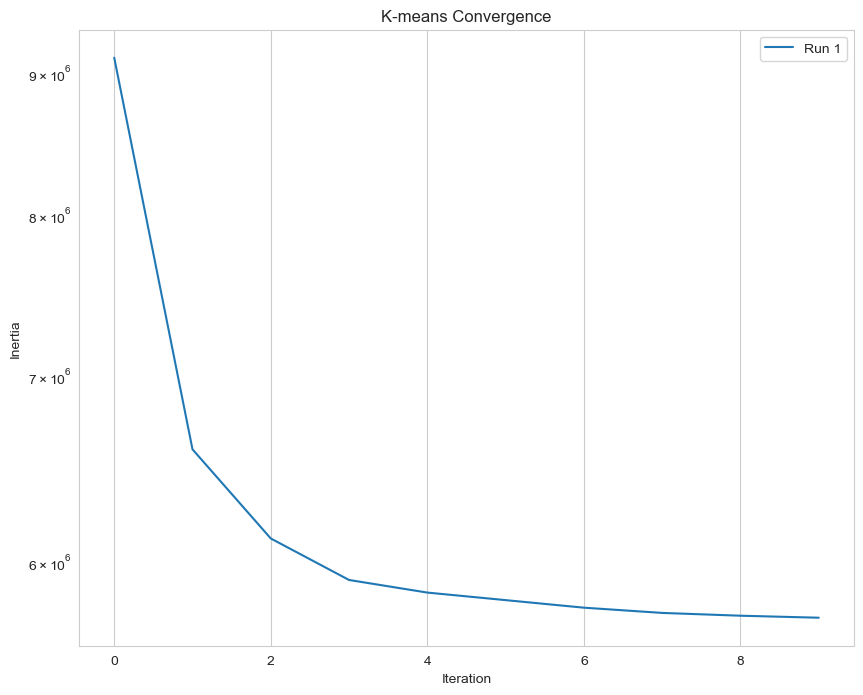

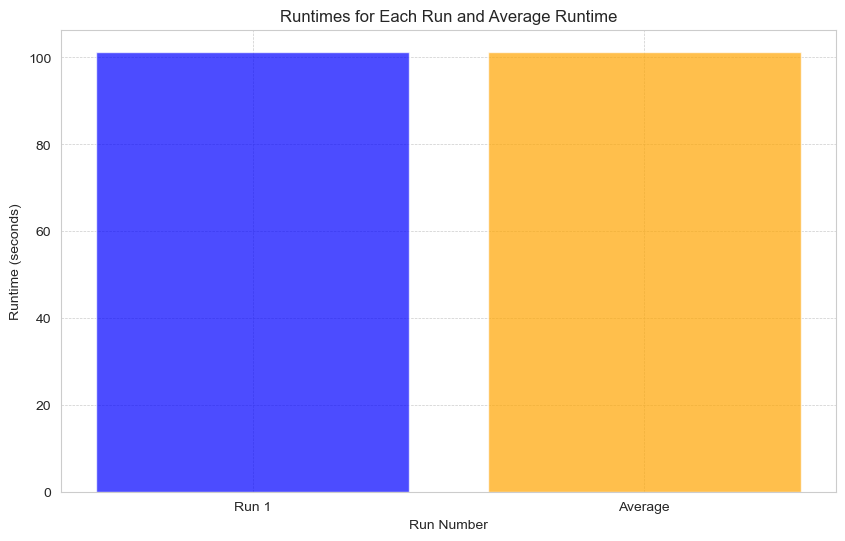

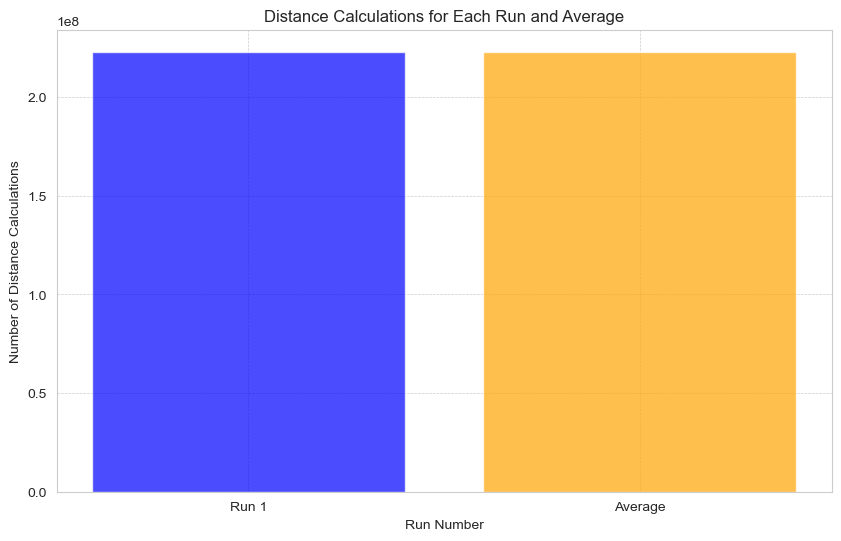

Average NMI Score: 0.1862


In [77]:
visualize_clustering_results(results_k_means)

# k-Means with Locality Sensitive Hashing (LSH)

We have implemented the lsh_has_function as given in the assignement.   
The hash function $h_{a,b}(p): \mathbb{R}^d \rightarrow \mathbb{N}$ maps a point $p \in \mathbb{R}^d$ to a natural number, defined as:   
$ h_{a,b}(p) = \left\lfloor \frac{{\mathbf{a \cdot p} + b}}{{w}} \right\rfloor $

Where:
- $a$ is a random vector in $\mathbb{R}^d$,
- $b$ is a scalar parameter in the range $[0, w]$,
- $w$ is a scalar parameter determining the width of the hash bins,
- $\mathbf{a \cdot p}$ denotes the dot product between vectors $a$ and $p$.

This is done in lsh_hash_function, so first we initialize the lsh with initialize_lsh, where we create a number of a and b vectors according to the number of hash funcs we want. Then we compute the hash signitatur for every point with compute_lsh_hashes

In [57]:
# Define the LSH hash function as a standalone function
def lsh_hash_function(X, a, b, w):
    """
    Computes the hash values for a dataset X using a single hash function.
    
    Parameters:
    X (numpy array): The dataset with shape (n, d), where n is the number of data points and d is the dimensionality.
    a (numpy array): A random vector for projection with shape (d,).
    b (float): A random offset.
    w (float): The bin width.
    
    Returns:
    numpy array: An array of hash values with shape (n,).
    """
    projection = X.dot(a)  # Project points onto vector a
    shifted_projection = projection + b  # Shift by offset b
    normalized_value = shifted_projection / w  # Normalize by bin width w
    bin_index = np.floor(normalized_value)  # Get bin index by flooring
    return bin_index

# Initialize LSH parameters and create a list of hash functions
def initialize_lsh(X, n, m, w):
    """
    Initializes parameters for LSH hash functions for a dataset.
    
    Parameters:
    X (numpy array): The dataset with shape (n, d), where n is the number of data points and d is the dimensionality.
    n (int): The number of groups of hash functions.
    m (int): The number of hash functions in each group.
    w (float): The bin width.
    
    Returns:
    tuple: A tuple containing the list of random vectors (a) and the list of random offsets (b).
    """
    
    # Get the number of data points (n) and the dimensionality (d)
    num_data_points, d = X.shape
    
    # Generate random vectors for projection, one for each hash function
    a = np.random.randn(n * m, d)
    
    # Generate random offsets for each hash function
    b = np.random.uniform(0, w, n * m)
    
    return a, b, w

# Compute hash values for all data points
def compute_lsh_hashes(X, a, b, w):
    """
    Computes the hash values for all data points in a dataset using a list of hash functions.
    
    Parameters:
    X (numpy array): The dataset with shape (n, d), where n is the number of data points and d is the dimensionality.
    a (numpy array): A list of random vectors for projection with shape (num_hashes, d).
    b (numpy array): A list of random offsets with shape (num_hashes,).
    w (float): The bin width.
    
    Returns:
    numpy array: An array of hash values with shape (n, num_hashes).
    """
    num_hashes = len(a)
    hashes = np.column_stack([lsh_hash_function(X, a[i], b[i], w) for i in range(num_hashes)])
    return hashes  # Convert list to numpy array

In [34]:
# Test data and parameters
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20]])
a = np.array([1, 0])  # Projection vector focusing on the first dimension
b = 0.5  # Offset
w = 2.0  # Bin width
expected_hashes = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Test lsh_hash_function
computed_hashes = lsh_hash_function(X, a, b, w)
assert np.array_equal(computed_hashes, expected_hashes), "Hash function test failed."

# Print result to verify
print("LSH hash function test passed.")
print("Computed hashes:", computed_hashes)

# Initialize LSH and test
n, m, w = 2, 3, 5.0  # 2 groups, 3 hash functions per group, bin width 5.0
a, b, _ = initialize_lsh(X, n, m, w)

# Test initialize_lsh shapes
assert a.shape == (n * m, X.shape[1]), "Random vectors shape mismatch."
assert b.shape == (n * m,), "Offsets shape mismatch."
print("Initialization test passed.")

# Test compute_lsh_hashes
computed_hashes_all = compute_lsh_hashes(X, a, b, w)
assert computed_hashes_all.shape == (X.shape[0], n * m), "Computed hashes shape mismatch."
print("All hashes computed correctly. Shape:", computed_hashes_all.shape)

# Additional verification by inspecting values
print("Random vectors (a):", a)
print("Random offsets (b):", b)
print("Computed hashes for all functions:\n", computed_hashes_all)

LSH hash function test passed.
Computed hashes: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Initialization test passed.
All hashes computed correctly. Shape: (10, 6)
Random vectors (a): [[ 0.9768232  -0.52932448]
 [-0.53569719  1.50149564]
 [ 2.1230244  -0.63311643]
 [ 0.4135722   1.68307639]
 [ 0.57969983  1.16208739]
 [ 1.22226751 -0.44350093]]
Random offsets (b): [4.42667662 4.25782255 0.24230048 0.79370407 0.6889154  1.0088757 ]
Computed hashes for all functions:
 [[0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0.]
 [1. 2. 1. 2. 2. 0.]
 [1. 2. 2. 3. 2. 1.]
 [1. 2. 2. 4. 3. 1.]
 [1. 3. 3. 5. 4. 1.]
 [1. 3. 3. 5. 4. 2.]
 [2. 4. 4. 6. 5. 2.]
 [2. 4. 4. 7. 6. 2.]
 [2. 4. 5. 8. 6. 3.]]



For the k- means our two most important algorithms are First, the number of data points in X is determined and stored in n_samples. An array labels is initialized to store the cluster assignment for each data point. The hash values for each centroid are computed and stored in centroid_hashes. An empty list hash_groups is initialized to store groups of hash functions, and a list bucket_random_points is initialized to store random points from each bucket (cluster).

Next, a loop runs n times to create n groups of m hash functions. For each group, the start and end indices for the current group of hash functions are determined, and the group of m hash functions is added to hash_groups.

Then, the function iterates over each point i in X. For each point, potential_centroids is initialized to track centroids that match the hash values. The function then checks each group of hash functions to see if all hashes in the group match between the point and the centroids. If a match is found, potential_centroids is updated with the matching results.

If any potential centroid matches are found, the distances from the point to all potential centroids are computed, and the point is assigned to the closest centroid. If no matches are found, a random point is selected, distances to all centroids are computed, and the point is assigned to the closest centroid. The point is then stored in bucket_random_points for its assigned centroid.

Finally, the function returns labels (cluster assignments) and bucket_random_points (random points from each bucket).

In [108]:
import numpy as np
import time
from tqdm import tqdm

def kmeans_lsh(X, k, max_iters=500, n=2, m=2, w=4.0):
    """
    Performs k-means clustering with Locality-Sensitive Hashing (LSH) for initialization.
    
    Parameters:
    X (numpy array): The dataset with shape (n_samples, n_features).
    k (int): The number of clusters.
    max_iters (int): The maximum number of iterations.
    n (int): The number of groups of hash functions.
    m (int): The number of hash functions in each group.
    w (float): The bin width for LSH.
    
    Returns:
    numpy array: The final cluster centroids.
    numpy array: The cluster assignments for each data point.
    int: The number of iterations run.
    list: The inertia history over the iterations.
    int: The total distance calculations.
    float: The runtime in seconds.
    """
    start_time = time.time()  # Start timing
    # Initialize LSH parameters and create hash functions
    a, b, w = initialize_lsh(X, n, m, w)
    
    # Compute LSH hash values for all data points
    hashes = compute_lsh_hashes(X, a, b, w)
    
    # Initialize the first k clusters by selecting k random points from X
    centroids = initialize_clusters(X, k)
    
    # Compute LSH hash values for all centroids
    centroid_hashes = compute_lsh_hashes(centroids, a, b, w)
    
    inertia_history = []
    total_distance_calculations = 0
    

    for iteration in tqdm(range(max_iters), desc="Clustering Progress"):
        # Assign points to the nearest centroid using LSH hash values
        cluster_assignments = assign_points_to_clusters(hashes, centroid_hashes, n, m, centroids, X)
        
        # Update centroids
        new_centroids = np.array([X[cluster_assignments == i].mean(axis=0) if np.any(cluster_assignments == i) else centroids[i] for i in range(k)])
        
        # Compute new LSH hash values for the new centroids
        new_centroid_hashes = compute_lsh_hashes(new_centroids, a, b, w)
        
        # Compute inertia (sum of squared distances to centroids)
        inertia = np.sum((X - new_centroids[cluster_assignments]) ** 2)
        inertia_history.append(inertia)
        total_distance_calculations += X.shape[0] * k
        
        # Check for convergence (if centroids do not change)
        if np.allclose(centroids, new_centroids):
            break
        
        centroids = new_centroids
        centroid_hashes = new_centroid_hashes  # Update centroid hashes
    
    runtime = time.time() - start_time  # End timing
    
    return centroids, cluster_assignments, iteration + 1, inertia_history, total_distance_calculations, runtime

def assign_points_to_clusters(hashes, centroid_hashes, n, m, centroids, X):
    num_samples = hashes.shape[0]
    num_clusters = centroid_hashes.shape[0]

    # Precompute blocks for efficiency
    point_blocks = hashes.reshape(num_samples, n, m)
    centroid_blocks = centroid_hashes.reshape(num_clusters, n, m)

    # Initialize cluster assignments to -1 (unassigned)
    cluster_assignments = np.full(num_samples, -1)
    
    # Use vectorized operations for hash comparisons
    for j in range(num_clusters):
        mask = np.any(np.all(point_blocks == centroid_blocks[j], axis=2), axis=1)
        cluster_assignments[mask] = j
    
    # For unassigned points, assign to the nearest centroid
    unassigned_points = np.where(cluster_assignments == -1)[0]
    if unassigned_points.size > 0:
        distances = np.linalg.norm(X[unassigned_points][:, np.newaxis] - centroids, axis=2)
        nearest_centroids = np.argmin(distances, axis=1)
        cluster_assignments[unassigned_points] = nearest_centroids
    
    return cluster_assignments


# Helper functions (define them separately)
def initialize_clusters(X, k):
    np.random.seed(42)  # Set a random seed for reproducibility
    initial_indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[initial_indices]
    return centroids

In [117]:
results_k_means_lsh = perform_clustering(
    X_scaled, 
    153, 
    50, 
    1, 
    kmeans_lsh
)


Clustering Progress: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


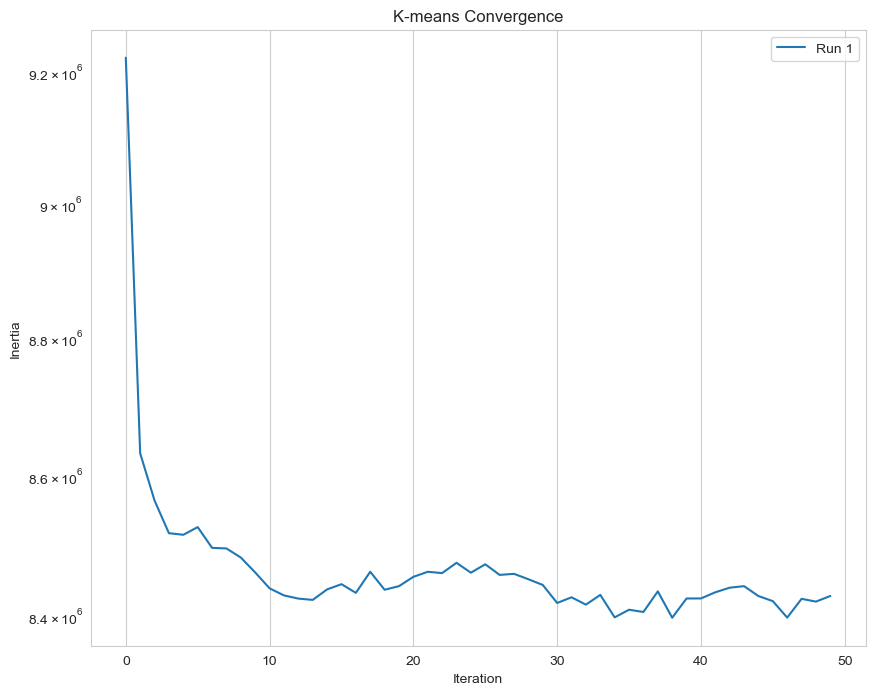

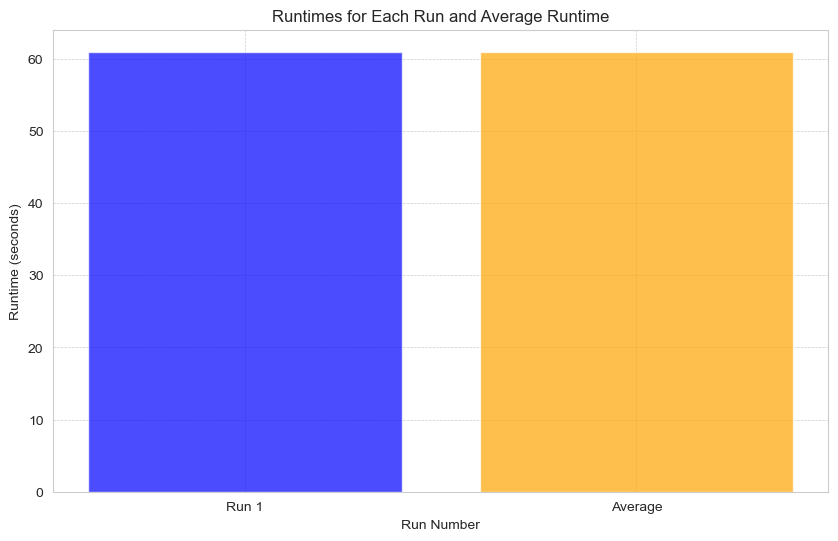

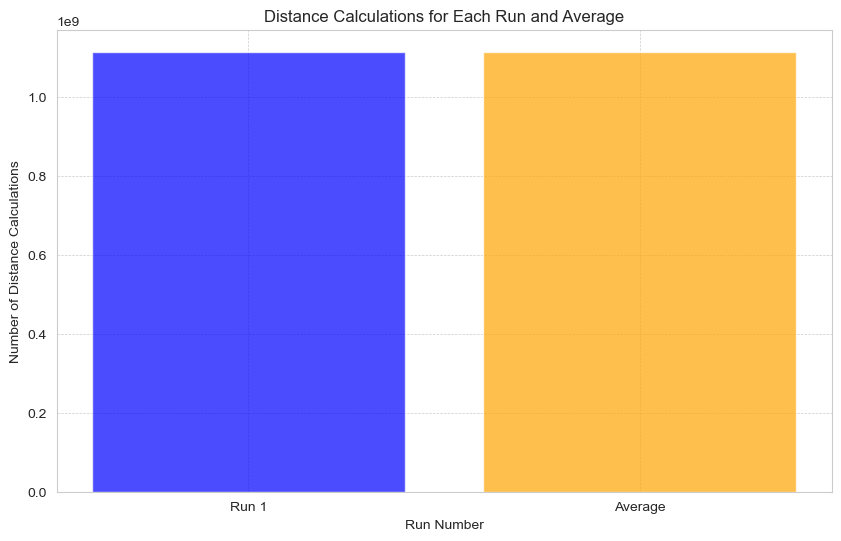

Average NMI Score: 0.0408


In [118]:
visualize_clustering_results(results_k_means_lsh)

K-means Iteration:  26%|██▌       | 13/50 [00:01<00:04,  7.40it/s]


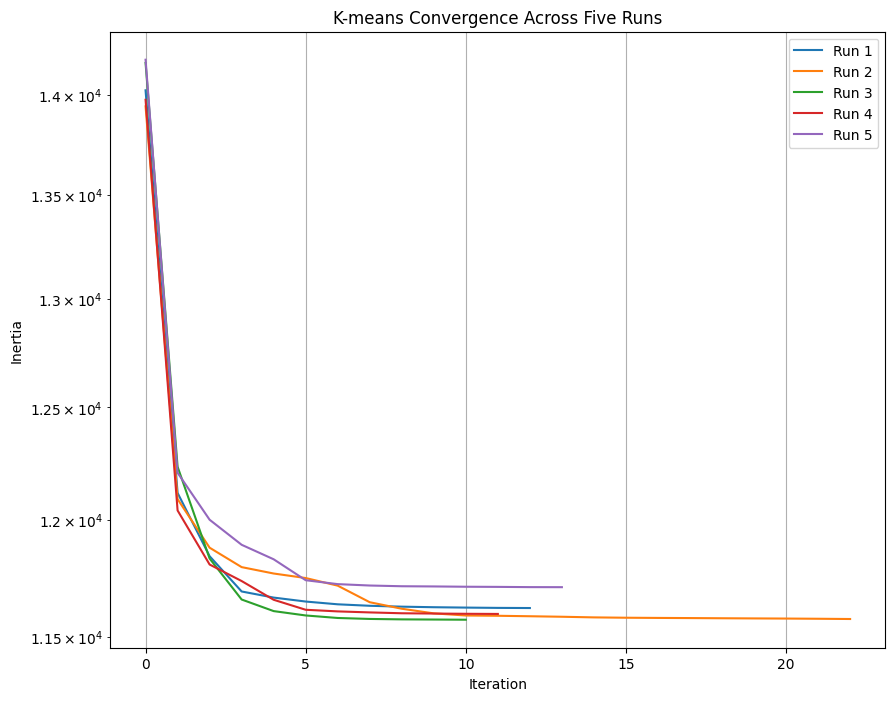

Average NMI Score over five runs: 0.3151


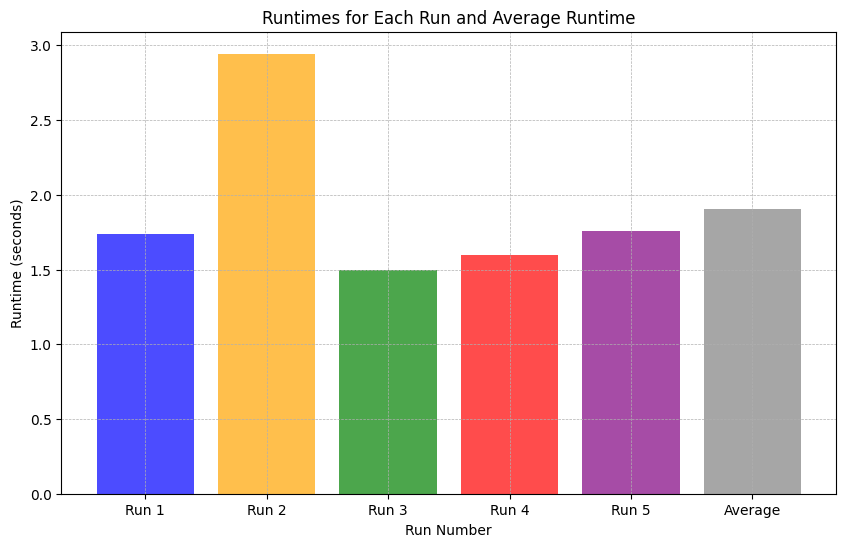

In [13]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def sample_coreset(X, k, m):
    # Simple random sampling for coreset
    indices = np.random.choice(X.shape[0], size=m, replace=False)
    return X[indices], np.ones(m) / m

def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    return labels, distances.min(axis=1).sum()

def update_centroids(X, labels, k, weights):
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        weighted_points = X[labels == i] * weights[labels == i, np.newaxis]
        centroids[i] = weighted_points.sum(axis=0) / weights[labels == i].sum()
    return centroids

def kmeans_coreset(X, k, coreset_size, max_iters=100):
    start_time = time.time()
    if coreset_size < k:
        raise ValueError(f"Coreset size {coreset_size} must be at least as large as k {k}.")
    
    start_time = time.time()
    # Step 1: Sample the coreset
    coreset, weights = sample_coreset(X, k, coreset_size)
    
    # Step 2: Run K-means on the coreset
    centroids = initialize_centroids(coreset, k)
    inertia_history = []
    total_distance_calculations = 0
    
    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels, inertia = assign_clusters(coreset, centroids)
        inertia_history.append(inertia)
        new_centroids = update_centroids(coreset, labels, k, weights)
        total_distance_calculations += coreset.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    
    # Step 3: Assign clusters to all points
    full_labels = assign_clusters(X, centroids)[0]
    return centroids, full_labels, i+1, inertia_history, total_distance_calculations, runtime


# Example usage with a dummy dataset
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    #X, true_labels = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42)
    k = 153
    max_iters = 50

# Lists to store results
all_labels = []
all_centroids = []
all_nmi_scores = []
all_runtimes = []
all_distance_calculations = []
all_inertia_histories = []
all_num_itertations = []

# Perform clustering five times
for i in range(5):
    centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans_coreset(X, k,2000, max_iters)
    nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
    
    # Append results to lists
    all_num_itertations.append(num_iterations)
    all_labels.append(labels)
    all_centroids.append(centroids)
    all_nmi_scores.append(nmi_score)
    all_runtimes.append(runtime)
    all_distance_calculations.append(distance_calculations)
    all_inertia_histories.append(inertia_history)

plt.figure(figsize=(10, 8))
for i, inertia_history in enumerate(all_inertia_histories):
    plt.plot(inertia_history, label=f'Run {i+1}')
plt.title('K-means Convergence Across Five Runs')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.legend()
plt.grid(True)
plt.show()


average_nmi = np.mean(all_nmi_scores)
print(f"Average NMI Score over five runs: {average_nmi:.4f}")

# Assuming `all_runtimes` contains the runtime for each of the five runs
average_runtime = np.mean(all_runtimes)
# Define a list of colors for the bars
colors = ['blue', 'orange', 'green','red',   'purple']

plt.figure(figsize=(10, 6))
bar_colors = colors + ['grey']  # Add grey color for the average bar
plt.bar(range(1, 7), all_runtimes + [average_runtime], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Runtime (seconds)')
plt.title('Runtimes for Each Run and Average Runtime')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

K-means Iteration:  10%|█         | 5/50 [00:00<00:02, 19.57it/s]


Variance of NMI scores for coreset size 500: 0.0000


K-means Iteration:  18%|█▊        | 9/50 [00:00<00:03, 10.75it/s]


Variance of NMI scores for coreset size 1000: 0.0000


K-means Iteration:  14%|█▍        | 7/50 [00:01<00:06,  6.99it/s]


Variance of NMI scores for coreset size 1500: 0.0000


K-means Iteration:  22%|██▏       | 11/50 [00:04<00:14,  2.73it/s]


Variance of NMI scores for coreset size 2000: 0.0000


K-means Iteration:  24%|██▍       | 12/50 [00:06<00:19,  1.91it/s]


Variance of NMI scores for coreset size 2500: 0.0000


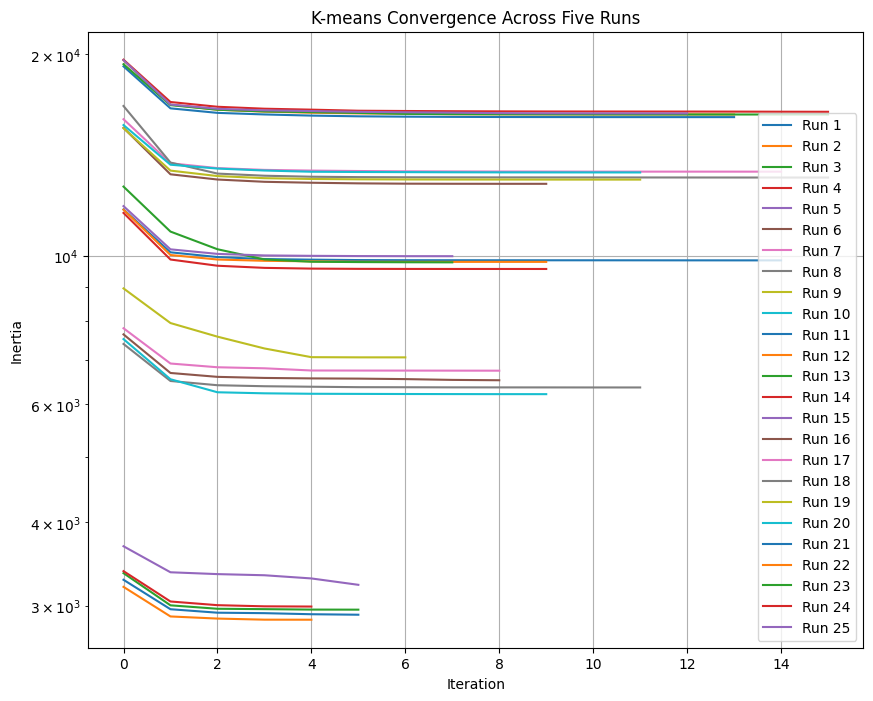

Average NMI Score over five runs: 0.2074


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6,) and arg 1 with shape (26,).

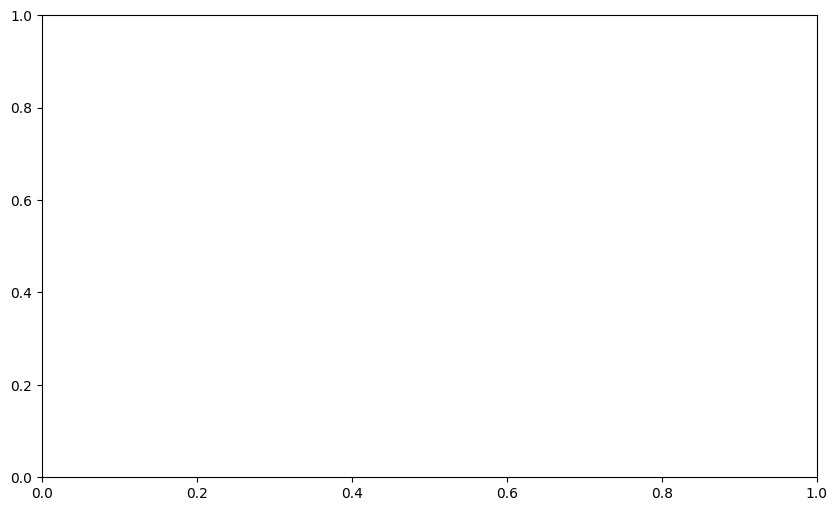

In [8]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def lightweight_coreset(X, k, m):
    n = X.shape[0]
    if n < m:
        print(f"Warning: The dataset size ({n}) is smaller than the coreset size ({m}). Consider allowing replacement or reducing the coreset size.")
        # Uncomment the next line to allow replacement if necessary
        return X, np.ones(n) / n  
    # Compute the mean of the data
    mu = np.mean(X, axis=0)
    # Compute distances from the mean
    dists_sq = np.sum((X - mu) ** 2, axis=1)
    total_dist_sq = np.sum(dists_sq)
    
    # Probability distribution for importance sampling
    q = 0.5 / X.shape[0] + 0.5 * dists_sq / total_dist_sq
    # Sampling according to q
    indices = np.random.choice(X.shape[0], size=m, replace=False, p=q / q.sum())
    # Compute weights inversely proportional to q
    weights = 1 / (m * q[indices])
    
    return X[indices], weights

def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    return labels, distances.min(axis=1).sum()

def update_centroids(X, labels, k, weights):


    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))
    for i in range(k):
        cluster_indices = labels == i
        if np.sum(weights[cluster_indices]) > 0:
            weighted_points = X[cluster_indices] * weights[cluster_indices, np.newaxis]
            centroids[i] = weighted_points.sum(axis=0) / weights[cluster_indices].sum()
        else:
            centroids[i] = X[np.random.choice(X.shape[0])]
    return centroids

def kmeans_coreset(X, k, coreset_size, max_iters=100):
    start_time = time.time()
    if coreset_size < k:
        print(f"Coreset size {coreset_size} must be at least as large as k {k}, therefore k is now coreset size")
        k = coreset_size
    
    # Step 1: Sample the lightweight coreset
    coreset, weights = lightweight_coreset(X, k, coreset_size)
    
    # Step 2: Run K-means on the coreset
    centroids = initialize_centroids(coreset, k)
    inertia_history = []
    total_distance_calculations = 0
    
    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels, inertia = assign_clusters(coreset, centroids)
        inertia_history.append(inertia)
        new_centroids = update_centroids(coreset, labels, k, weights)
        total_distance_calculations += coreset.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    
    # Step 3: Assign clusters to all points
    full_labels = assign_clusters(X, centroids)[0]
    return centroids, full_labels, i+1, inertia_history, total_distance_calculations, runtime

# Example usage with a dummy dataset
if __name__ == "__main__":

    k = 153
    max_iters = 50
    
    # Lists to store results
    all_labels = []
    all_centroids = []
    all_nmi_scores = []
    all_runtimes = []
    all_distance_calculations = []
    all_inertia_histories = []
    all_num_iterations = []

    for i in range(5):
        centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans_coreset(X, k, coreset_size, max_iters)
        nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')

        # Append results to lists
        all_num_iterations.append(num_iterations)
        all_labels.append(labels)
        all_centroids.append(centroids)
        all_nmi_scores.append(nmi_score)
        all_runtimes.append(runtime)
        all_distance_calculations.append(distance_calculations)
        all_inertia_histories.append(inertia_history)


    plt.figure(figsize=(10, 8))
    for i, inertia_history in enumerate(all_inertia_histories):
        plt.plot(inertia_history, label=f'Run {i+1}')
    plt.title('K-means Convergence Across Five Runs')
    plt.xlabel('Iteration')
    plt.ylabel('Inertia')
    plt.yscale('log')  # Set the y-axis to a logarithmic scale
    plt.legend()
    plt.grid(True)
    plt.show()

    average_nmi = np.mean(all_nmi_scores)
    print(f"Average NMI Score over five runs: {average_nmi:.4f}")

    # Assuming `all_runtimes` contains the runtime for each of the five runs
    average_runtime = np.mean(all_runtimes)
    # Define a list of colors for the bars
    colors = ['blue', 'orange', 'green','red',   'purple']

    plt.figure(figsize=(10, 6))
    bar_colors = colors + ['grey']  # Add grey color for the average bar
    plt.bar(range(1, 7), all_runtimes + [average_runtime], color=bar_colors, alpha=0.7)
    plt.xlabel('Run Number')
    plt.ylabel('Runtime (seconds)')
    plt.title('Runtimes for Each Run and Average Runtime')
    plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


In [9]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def lightweight_coreset(X, k, m):
    n = X.shape[0]
    if n < m:
        print(f"Warning: The dataset size ({n}) is smaller than the coreset size ({m}). Consider allowing replacement or reducing the coreset size.")
        return X, np.ones(n) / n, np.arange(n)
    # Compute the mean of the data
    mu = np.mean(X, axis=0)
    # Compute distances from the mean
    dists_sq = np.sum((X - mu) ** 2, axis=1)
    total_dist_sq = np.sum(dists_sq)
    
    # Probability distribution for importance sampling
    q = 0.5 / X.shape[0] + 0.5 * dists_sq / total_dist_sq
    # Sampling according to q
    indices = np.random.choice(X.shape[0], size=m, replace=False, p=q / q.sum())
    # Compute weights inversely proportional to q
    weights = 1 / (m * q[indices])
    # for all points in the coreset now calculate the variance of the indices
    for i in range(m):
        points = X[indices]
        variance = np.var(points, axis=0)
        # calculate the mean variance
        mean_variance = np.mean(variance)
        print(f"Point {i}: Variance = {mean_variance:.4f}")

        
    
    return X[indices], weights

def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    return labels, distances.min(axis=1).sum()

def update_centroids(X, labels, k, weights):
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))
    for i in range(k):
        cluster_indices = labels == i
        if np.sum(weights[cluster_indices]) > 0:
            weighted_points = X[cluster_indices] * weights[cluster_indices, np.newaxis]
            centroids[i] = weighted_points.sum(axis=0) / weights[cluster_indices].sum()
        else:
            centroids[i] = X[np.random.choice(X.shape[0])]
    return centroids

def kmeans_coreset(X, k, coreset_size, max_iters=100):
    start_time = time.time()
    if coreset_size < k:
        print(f"Coreset size {coreset_size} must be at least as large as k {k}, therefore k is now coreset size")
        k = coreset_size
    
    # Step 1: Sample the lightweight coreset
    coreset, weights = lightweight_coreset(X, k, coreset_size)
    
    # Step 2: Run K-means on the coreset
    centroids = initialize_centroids(coreset, k)
    inertia_history = []
    total_distance_calculations = 0
    
    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels, inertia = assign_clusters(coreset, centroids)
        inertia_history.append(inertia)
        new_centroids = update_centroids(coreset, labels, k, weights)
        total_distance_calculations += coreset.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    
    # Step 3: Assign clusters to all points
    full_labels = assign_clusters(X, centroids)[0]
    return centroids, full_labels, i+1, inertia_history, total_distance_calculations, runtime

# Example usage with a dummy dataset
if __name__ == "__main__":

    k = 153
    max_iters = 50
    coreset_sizes = [250,500, 1000, 2000, 5000,]

    # Lists to store results
    results = {m: {"nmi_scores": [], "runtimes": [], "distance_calculations": [], "num_iterations": [], "indices": []} for m in coreset_sizes}

    for m in coreset_sizes:
        for _ in range(5):
            centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans_coreset(X, k, m, max_iters)
            nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')

            # Append results to lists
            results[m]["nmi_scores"].append(nmi_score)
            results[m]["runtimes"].append(runtime)
            results[m]["distance_calculations"].append(distance_calculations)
            results[m]["num_iterations"].append(num_iterations)




Point 0: Variance = 15.9353
Point 1: Variance = 15.9353
Point 2: Variance = 15.9353
Point 3: Variance = 15.9353
Point 4: Variance = 15.9353
Point 5: Variance = 15.9353
Point 6: Variance = 15.9353
Point 7: Variance = 15.9353
Point 8: Variance = 15.9353
Point 9: Variance = 15.9353
Point 10: Variance = 15.9353
Point 11: Variance = 15.9353
Point 12: Variance = 15.9353
Point 13: Variance = 15.9353
Point 14: Variance = 15.9353
Point 15: Variance = 15.9353
Point 16: Variance = 15.9353
Point 17: Variance = 15.9353
Point 18: Variance = 15.9353
Point 19: Variance = 15.9353
Point 20: Variance = 15.9353
Point 21: Variance = 15.9353
Point 22: Variance = 15.9353
Point 23: Variance = 15.9353
Point 24: Variance = 15.9353
Point 25: Variance = 15.9353
Point 26: Variance = 15.9353
Point 27: Variance = 15.9353
Point 28: Variance = 15.9353
Point 29: Variance = 15.9353
Point 30: Variance = 15.9353
Point 31: Variance = 15.9353
Point 32: Variance = 15.9353
Point 33: Variance = 15.9353
Point 34: Variance = 15.

K-means Iteration:   2%|▏         | 1/50 [00:00<00:02, 16.63it/s]


Point 0: Variance = 15.9341
Point 1: Variance = 15.9341
Point 2: Variance = 15.9341
Point 3: Variance = 15.9341
Point 4: Variance = 15.9341
Point 5: Variance = 15.9341
Point 6: Variance = 15.9341
Point 7: Variance = 15.9341
Point 8: Variance = 15.9341
Point 9: Variance = 15.9341
Point 10: Variance = 15.9341
Point 11: Variance = 15.9341
Point 12: Variance = 15.9341
Point 13: Variance = 15.9341
Point 14: Variance = 15.9341
Point 15: Variance = 15.9341
Point 16: Variance = 15.9341
Point 17: Variance = 15.9341
Point 18: Variance = 15.9341
Point 19: Variance = 15.9341
Point 20: Variance = 15.9341
Point 21: Variance = 15.9341
Point 22: Variance = 15.9341
Point 23: Variance = 15.9341
Point 24: Variance = 15.9341
Point 25: Variance = 15.9341
Point 26: Variance = 15.9341
Point 27: Variance = 15.9341
Point 28: Variance = 15.9341
Point 29: Variance = 15.9341
Point 30: Variance = 15.9341
Point 31: Variance = 15.9341
Point 32: Variance = 15.9341
Point 33: Variance = 15.9341
Point 34: Variance = 15.

K-means Iteration:   4%|▍         | 2/50 [00:00<00:02, 19.04it/s]


Point 0: Variance = 14.1575
Point 1: Variance = 14.1575
Point 2: Variance = 14.1575
Point 3: Variance = 14.1575
Point 4: Variance = 14.1575
Point 5: Variance = 14.1575
Point 6: Variance = 14.1575
Point 7: Variance = 14.1575
Point 8: Variance = 14.1575
Point 9: Variance = 14.1575
Point 10: Variance = 14.1575
Point 11: Variance = 14.1575
Point 12: Variance = 14.1575
Point 13: Variance = 14.1575
Point 14: Variance = 14.1575
Point 15: Variance = 14.1575
Point 16: Variance = 14.1575
Point 17: Variance = 14.1575
Point 18: Variance = 14.1575
Point 19: Variance = 14.1575
Point 20: Variance = 14.1575
Point 21: Variance = 14.1575
Point 22: Variance = 14.1575
Point 23: Variance = 14.1575
Point 24: Variance = 14.1575
Point 25: Variance = 14.1575
Point 26: Variance = 14.1575
Point 27: Variance = 14.1575
Point 28: Variance = 14.1575
Point 29: Variance = 14.1575
Point 30: Variance = 14.1575
Point 31: Variance = 14.1575
Point 32: Variance = 14.1575
Point 33: Variance = 14.1575
Point 34: Variance = 14.

K-means Iteration:   4%|▍         | 2/50 [00:00<00:02, 21.38it/s]


Point 0: Variance = 15.5942
Point 1: Variance = 15.5942
Point 2: Variance = 15.5942
Point 3: Variance = 15.5942
Point 4: Variance = 15.5942
Point 5: Variance = 15.5942
Point 6: Variance = 15.5942
Point 7: Variance = 15.5942
Point 8: Variance = 15.5942
Point 9: Variance = 15.5942
Point 10: Variance = 15.5942
Point 11: Variance = 15.5942
Point 12: Variance = 15.5942
Point 13: Variance = 15.5942
Point 14: Variance = 15.5942
Point 15: Variance = 15.5942
Point 16: Variance = 15.5942
Point 17: Variance = 15.5942
Point 18: Variance = 15.5942
Point 19: Variance = 15.5942
Point 20: Variance = 15.5942
Point 21: Variance = 15.5942
Point 22: Variance = 15.5942
Point 23: Variance = 15.5942
Point 24: Variance = 15.5942
Point 25: Variance = 15.5942
Point 26: Variance = 15.5942
Point 27: Variance = 15.5942
Point 28: Variance = 15.5942
Point 29: Variance = 15.5942
Point 30: Variance = 15.5942
Point 31: Variance = 15.5942
Point 32: Variance = 15.5942
Point 33: Variance = 15.5942
Point 34: Variance = 15.

K-means Iteration:   4%|▍         | 2/50 [00:00<00:02, 19.57it/s]


Point 0: Variance = 14.6950
Point 1: Variance = 14.6950
Point 2: Variance = 14.6950
Point 3: Variance = 14.6950
Point 4: Variance = 14.6950
Point 5: Variance = 14.6950
Point 6: Variance = 14.6950
Point 7: Variance = 14.6950
Point 8: Variance = 14.6950
Point 9: Variance = 14.6950
Point 10: Variance = 14.6950
Point 11: Variance = 14.6950
Point 12: Variance = 14.6950
Point 13: Variance = 14.6950
Point 14: Variance = 14.6950
Point 15: Variance = 14.6950
Point 16: Variance = 14.6950
Point 17: Variance = 14.6950
Point 18: Variance = 14.6950
Point 19: Variance = 14.6950
Point 20: Variance = 14.6950
Point 21: Variance = 14.6950
Point 22: Variance = 14.6950
Point 23: Variance = 14.6950
Point 24: Variance = 14.6950
Point 25: Variance = 14.6950
Point 26: Variance = 14.6950
Point 27: Variance = 14.6950
Point 28: Variance = 14.6950
Point 29: Variance = 14.6950
Point 30: Variance = 14.6950
Point 31: Variance = 14.6950
Point 32: Variance = 14.6950
Point 33: Variance = 14.6950
Point 34: Variance = 14.

K-means Iteration:   2%|▏         | 1/50 [00:00<00:02, 21.74it/s]


Point 0: Variance = 10.2841
Point 1: Variance = 10.2841
Point 2: Variance = 10.2841
Point 3: Variance = 10.2841
Point 4: Variance = 10.2841
Point 5: Variance = 10.2841
Point 6: Variance = 10.2841
Point 7: Variance = 10.2841
Point 8: Variance = 10.2841
Point 9: Variance = 10.2841
Point 10: Variance = 10.2841
Point 11: Variance = 10.2841
Point 12: Variance = 10.2841
Point 13: Variance = 10.2841
Point 14: Variance = 10.2841
Point 15: Variance = 10.2841
Point 16: Variance = 10.2841
Point 17: Variance = 10.2841
Point 18: Variance = 10.2841
Point 19: Variance = 10.2841
Point 20: Variance = 10.2841
Point 21: Variance = 10.2841
Point 22: Variance = 10.2841
Point 23: Variance = 10.2841
Point 24: Variance = 10.2841
Point 25: Variance = 10.2841
Point 26: Variance = 10.2841
Point 27: Variance = 10.2841
Point 28: Variance = 10.2841
Point 29: Variance = 10.2841
Point 30: Variance = 10.2841
Point 31: Variance = 10.2841
Point 32: Variance = 10.2841
Point 33: Variance = 10.2841
Point 34: Variance = 10.

K-means Iteration:  14%|█▍        | 7/50 [00:00<00:02, 19.33it/s]


Point 0: Variance = 10.3144
Point 1: Variance = 10.3144
Point 2: Variance = 10.3144
Point 3: Variance = 10.3144
Point 4: Variance = 10.3144
Point 5: Variance = 10.3144
Point 6: Variance = 10.3144
Point 7: Variance = 10.3144
Point 8: Variance = 10.3144
Point 9: Variance = 10.3144
Point 10: Variance = 10.3144
Point 11: Variance = 10.3144
Point 12: Variance = 10.3144
Point 13: Variance = 10.3144
Point 14: Variance = 10.3144
Point 15: Variance = 10.3144
Point 16: Variance = 10.3144
Point 17: Variance = 10.3144
Point 18: Variance = 10.3144
Point 19: Variance = 10.3144
Point 20: Variance = 10.3144
Point 21: Variance = 10.3144
Point 22: Variance = 10.3144
Point 23: Variance = 10.3144
Point 24: Variance = 10.3144
Point 25: Variance = 10.3144
Point 26: Variance = 10.3144
Point 27: Variance = 10.3144
Point 28: Variance = 10.3144
Point 29: Variance = 10.3144
Point 30: Variance = 10.3144
Point 31: Variance = 10.3144
Point 32: Variance = 10.3144
Point 33: Variance = 10.3144
Point 34: Variance = 10.

K-means Iteration:   8%|▊         | 4/50 [00:00<00:03, 14.73it/s]


Point 0: Variance = 8.9710
Point 1: Variance = 8.9710
Point 2: Variance = 8.9710
Point 3: Variance = 8.9710
Point 4: Variance = 8.9710
Point 5: Variance = 8.9710
Point 6: Variance = 8.9710
Point 7: Variance = 8.9710
Point 8: Variance = 8.9710
Point 9: Variance = 8.9710
Point 10: Variance = 8.9710
Point 11: Variance = 8.9710
Point 12: Variance = 8.9710
Point 13: Variance = 8.9710
Point 14: Variance = 8.9710
Point 15: Variance = 8.9710
Point 16: Variance = 8.9710
Point 17: Variance = 8.9710
Point 18: Variance = 8.9710
Point 19: Variance = 8.9710
Point 20: Variance = 8.9710
Point 21: Variance = 8.9710
Point 22: Variance = 8.9710
Point 23: Variance = 8.9710
Point 24: Variance = 8.9710
Point 25: Variance = 8.9710
Point 26: Variance = 8.9710
Point 27: Variance = 8.9710
Point 28: Variance = 8.9710
Point 29: Variance = 8.9710
Point 30: Variance = 8.9710
Point 31: Variance = 8.9710
Point 32: Variance = 8.9710
Point 33: Variance = 8.9710
Point 34: Variance = 8.9710
Point 35: Variance = 8.9710
Po

K-means Iteration:   8%|▊         | 4/50 [00:00<00:03, 15.25it/s]


Point 0: Variance = 10.5523
Point 1: Variance = 10.5523
Point 2: Variance = 10.5523
Point 3: Variance = 10.5523
Point 4: Variance = 10.5523
Point 5: Variance = 10.5523
Point 6: Variance = 10.5523
Point 7: Variance = 10.5523
Point 8: Variance = 10.5523
Point 9: Variance = 10.5523
Point 10: Variance = 10.5523
Point 11: Variance = 10.5523
Point 12: Variance = 10.5523
Point 13: Variance = 10.5523
Point 14: Variance = 10.5523
Point 15: Variance = 10.5523
Point 16: Variance = 10.5523
Point 17: Variance = 10.5523
Point 18: Variance = 10.5523
Point 19: Variance = 10.5523
Point 20: Variance = 10.5523
Point 21: Variance = 10.5523
Point 22: Variance = 10.5523
Point 23: Variance = 10.5523
Point 24: Variance = 10.5523
Point 25: Variance = 10.5523
Point 26: Variance = 10.5523
Point 27: Variance = 10.5523
Point 28: Variance = 10.5523
Point 29: Variance = 10.5523
Point 30: Variance = 10.5523
Point 31: Variance = 10.5523
Point 32: Variance = 10.5523
Point 33: Variance = 10.5523
Point 34: Variance = 10.

K-means Iteration:   6%|▌         | 3/50 [00:00<00:03, 15.33it/s]


Point 0: Variance = 8.7588
Point 1: Variance = 8.7588
Point 2: Variance = 8.7588
Point 3: Variance = 8.7588
Point 4: Variance = 8.7588
Point 5: Variance = 8.7588
Point 6: Variance = 8.7588
Point 7: Variance = 8.7588
Point 8: Variance = 8.7588
Point 9: Variance = 8.7588
Point 10: Variance = 8.7588
Point 11: Variance = 8.7588
Point 12: Variance = 8.7588
Point 13: Variance = 8.7588
Point 14: Variance = 8.7588
Point 15: Variance = 8.7588
Point 16: Variance = 8.7588
Point 17: Variance = 8.7588
Point 18: Variance = 8.7588
Point 19: Variance = 8.7588
Point 20: Variance = 8.7588
Point 21: Variance = 8.7588
Point 22: Variance = 8.7588
Point 23: Variance = 8.7588
Point 24: Variance = 8.7588
Point 25: Variance = 8.7588
Point 26: Variance = 8.7588
Point 27: Variance = 8.7588
Point 28: Variance = 8.7588
Point 29: Variance = 8.7588
Point 30: Variance = 8.7588
Point 31: Variance = 8.7588
Point 32: Variance = 8.7588
Point 33: Variance = 8.7588
Point 34: Variance = 8.7588
Point 35: Variance = 8.7588
Po

K-means Iteration:   6%|▌         | 3/50 [00:00<00:03, 14.34it/s]


Point 0: Variance = 6.4657
Point 1: Variance = 6.4657
Point 2: Variance = 6.4657
Point 3: Variance = 6.4657
Point 4: Variance = 6.4657
Point 5: Variance = 6.4657
Point 6: Variance = 6.4657
Point 7: Variance = 6.4657
Point 8: Variance = 6.4657
Point 9: Variance = 6.4657
Point 10: Variance = 6.4657
Point 11: Variance = 6.4657
Point 12: Variance = 6.4657
Point 13: Variance = 6.4657
Point 14: Variance = 6.4657
Point 15: Variance = 6.4657
Point 16: Variance = 6.4657
Point 17: Variance = 6.4657
Point 18: Variance = 6.4657
Point 19: Variance = 6.4657
Point 20: Variance = 6.4657
Point 21: Variance = 6.4657
Point 22: Variance = 6.4657
Point 23: Variance = 6.4657
Point 24: Variance = 6.4657
Point 25: Variance = 6.4657
Point 26: Variance = 6.4657
Point 27: Variance = 6.4657
Point 28: Variance = 6.4657
Point 29: Variance = 6.4657
Point 30: Variance = 6.4657
Point 31: Variance = 6.4657
Point 32: Variance = 6.4657
Point 33: Variance = 6.4657
Point 34: Variance = 6.4657
Point 35: Variance = 6.4657
Po

K-means Iteration:  14%|█▍        | 7/50 [00:00<00:04, 10.66it/s]


Point 0: Variance = 5.9989
Point 1: Variance = 5.9989
Point 2: Variance = 5.9989
Point 3: Variance = 5.9989
Point 4: Variance = 5.9989
Point 5: Variance = 5.9989
Point 6: Variance = 5.9989
Point 7: Variance = 5.9989
Point 8: Variance = 5.9989
Point 9: Variance = 5.9989
Point 10: Variance = 5.9989
Point 11: Variance = 5.9989
Point 12: Variance = 5.9989
Point 13: Variance = 5.9989
Point 14: Variance = 5.9989
Point 15: Variance = 5.9989
Point 16: Variance = 5.9989
Point 17: Variance = 5.9989
Point 18: Variance = 5.9989
Point 19: Variance = 5.9989
Point 20: Variance = 5.9989
Point 21: Variance = 5.9989
Point 22: Variance = 5.9989
Point 23: Variance = 5.9989
Point 24: Variance = 5.9989
Point 25: Variance = 5.9989
Point 26: Variance = 5.9989
Point 27: Variance = 5.9989
Point 28: Variance = 5.9989
Point 29: Variance = 5.9989
Point 30: Variance = 5.9989
Point 31: Variance = 5.9989
Point 32: Variance = 5.9989
Point 33: Variance = 5.9989
Point 34: Variance = 5.9989
Point 35: Variance = 5.9989
Po

K-means Iteration:  10%|█         | 5/50 [00:00<00:04, 10.40it/s]


Point 0: Variance = 6.2246
Point 1: Variance = 6.2246
Point 2: Variance = 6.2246
Point 3: Variance = 6.2246
Point 4: Variance = 6.2246
Point 5: Variance = 6.2246
Point 6: Variance = 6.2246
Point 7: Variance = 6.2246
Point 8: Variance = 6.2246
Point 9: Variance = 6.2246
Point 10: Variance = 6.2246
Point 11: Variance = 6.2246
Point 12: Variance = 6.2246
Point 13: Variance = 6.2246
Point 14: Variance = 6.2246
Point 15: Variance = 6.2246
Point 16: Variance = 6.2246
Point 17: Variance = 6.2246
Point 18: Variance = 6.2246
Point 19: Variance = 6.2246
Point 20: Variance = 6.2246
Point 21: Variance = 6.2246
Point 22: Variance = 6.2246
Point 23: Variance = 6.2246
Point 24: Variance = 6.2246
Point 25: Variance = 6.2246
Point 26: Variance = 6.2246
Point 27: Variance = 6.2246
Point 28: Variance = 6.2246
Point 29: Variance = 6.2246
Point 30: Variance = 6.2246
Point 31: Variance = 6.2246
Point 32: Variance = 6.2246
Point 33: Variance = 6.2246
Point 34: Variance = 6.2246
Point 35: Variance = 6.2246
Po

K-means Iteration:  12%|█▏        | 6/50 [00:00<00:04,  9.17it/s]


Point 0: Variance = 6.4454
Point 1: Variance = 6.4454
Point 2: Variance = 6.4454
Point 3: Variance = 6.4454
Point 4: Variance = 6.4454
Point 5: Variance = 6.4454
Point 6: Variance = 6.4454
Point 7: Variance = 6.4454
Point 8: Variance = 6.4454
Point 9: Variance = 6.4454
Point 10: Variance = 6.4454
Point 11: Variance = 6.4454
Point 12: Variance = 6.4454
Point 13: Variance = 6.4454
Point 14: Variance = 6.4454
Point 15: Variance = 6.4454
Point 16: Variance = 6.4454
Point 17: Variance = 6.4454
Point 18: Variance = 6.4454
Point 19: Variance = 6.4454
Point 20: Variance = 6.4454
Point 21: Variance = 6.4454
Point 22: Variance = 6.4454
Point 23: Variance = 6.4454
Point 24: Variance = 6.4454
Point 25: Variance = 6.4454
Point 26: Variance = 6.4454
Point 27: Variance = 6.4454
Point 28: Variance = 6.4454
Point 29: Variance = 6.4454
Point 30: Variance = 6.4454
Point 31: Variance = 6.4454
Point 32: Variance = 6.4454
Point 33: Variance = 6.4454
Point 34: Variance = 6.4454
Point 35: Variance = 6.4454
Po

K-means Iteration:  10%|█         | 5/50 [00:00<00:05,  8.92it/s]


Point 0: Variance = 6.1971
Point 1: Variance = 6.1971
Point 2: Variance = 6.1971
Point 3: Variance = 6.1971
Point 4: Variance = 6.1971
Point 5: Variance = 6.1971
Point 6: Variance = 6.1971
Point 7: Variance = 6.1971
Point 8: Variance = 6.1971
Point 9: Variance = 6.1971
Point 10: Variance = 6.1971
Point 11: Variance = 6.1971
Point 12: Variance = 6.1971
Point 13: Variance = 6.1971
Point 14: Variance = 6.1971
Point 15: Variance = 6.1971
Point 16: Variance = 6.1971
Point 17: Variance = 6.1971
Point 18: Variance = 6.1971
Point 19: Variance = 6.1971
Point 20: Variance = 6.1971
Point 21: Variance = 6.1971
Point 22: Variance = 6.1971
Point 23: Variance = 6.1971
Point 24: Variance = 6.1971
Point 25: Variance = 6.1971
Point 26: Variance = 6.1971
Point 27: Variance = 6.1971
Point 28: Variance = 6.1971
Point 29: Variance = 6.1971
Point 30: Variance = 6.1971
Point 31: Variance = 6.1971
Point 32: Variance = 6.1971
Point 33: Variance = 6.1971
Point 34: Variance = 6.1971
Point 35: Variance = 6.1971
Po

K-means Iteration:  12%|█▏        | 6/50 [00:00<00:04, 10.53it/s]


Point 0: Variance = 4.0480
Point 1: Variance = 4.0480
Point 2: Variance = 4.0480
Point 3: Variance = 4.0480
Point 4: Variance = 4.0480
Point 5: Variance = 4.0480
Point 6: Variance = 4.0480
Point 7: Variance = 4.0480
Point 8: Variance = 4.0480
Point 9: Variance = 4.0480
Point 10: Variance = 4.0480
Point 11: Variance = 4.0480
Point 12: Variance = 4.0480
Point 13: Variance = 4.0480
Point 14: Variance = 4.0480
Point 15: Variance = 4.0480
Point 16: Variance = 4.0480
Point 17: Variance = 4.0480
Point 18: Variance = 4.0480
Point 19: Variance = 4.0480
Point 20: Variance = 4.0480
Point 21: Variance = 4.0480
Point 22: Variance = 4.0480
Point 23: Variance = 4.0480
Point 24: Variance = 4.0480
Point 25: Variance = 4.0480
Point 26: Variance = 4.0480
Point 27: Variance = 4.0480
Point 28: Variance = 4.0480
Point 29: Variance = 4.0480
Point 30: Variance = 4.0480
Point 31: Variance = 4.0480
Point 32: Variance = 4.0480
Point 33: Variance = 4.0480
Point 34: Variance = 4.0480
Point 35: Variance = 4.0480
Po

K-means Iteration:  24%|██▍       | 12/50 [00:02<00:07,  5.18it/s]


Point 0: Variance = 3.9783
Point 1: Variance = 3.9783
Point 2: Variance = 3.9783
Point 3: Variance = 3.9783
Point 4: Variance = 3.9783
Point 5: Variance = 3.9783
Point 6: Variance = 3.9783
Point 7: Variance = 3.9783
Point 8: Variance = 3.9783
Point 9: Variance = 3.9783
Point 10: Variance = 3.9783
Point 11: Variance = 3.9783
Point 12: Variance = 3.9783
Point 13: Variance = 3.9783
Point 14: Variance = 3.9783
Point 15: Variance = 3.9783
Point 16: Variance = 3.9783
Point 17: Variance = 3.9783
Point 18: Variance = 3.9783
Point 19: Variance = 3.9783
Point 20: Variance = 3.9783
Point 21: Variance = 3.9783
Point 22: Variance = 3.9783
Point 23: Variance = 3.9783
Point 24: Variance = 3.9783
Point 25: Variance = 3.9783
Point 26: Variance = 3.9783
Point 27: Variance = 3.9783
Point 28: Variance = 3.9783
Point 29: Variance = 3.9783
Point 30: Variance = 3.9783
Point 31: Variance = 3.9783
Point 32: Variance = 3.9783
Point 33: Variance = 3.9783
Point 34: Variance = 3.9783
Point 35: Variance = 3.9783
Po

K-means Iteration:  18%|█▊        | 9/50 [00:01<00:07,  5.18it/s]


Point 0: Variance = 3.9064
Point 1: Variance = 3.9064
Point 2: Variance = 3.9064
Point 3: Variance = 3.9064
Point 4: Variance = 3.9064
Point 5: Variance = 3.9064
Point 6: Variance = 3.9064
Point 7: Variance = 3.9064
Point 8: Variance = 3.9064
Point 9: Variance = 3.9064
Point 10: Variance = 3.9064
Point 11: Variance = 3.9064
Point 12: Variance = 3.9064
Point 13: Variance = 3.9064
Point 14: Variance = 3.9064
Point 15: Variance = 3.9064
Point 16: Variance = 3.9064
Point 17: Variance = 3.9064
Point 18: Variance = 3.9064
Point 19: Variance = 3.9064
Point 20: Variance = 3.9064
Point 21: Variance = 3.9064
Point 22: Variance = 3.9064
Point 23: Variance = 3.9064
Point 24: Variance = 3.9064
Point 25: Variance = 3.9064
Point 26: Variance = 3.9064
Point 27: Variance = 3.9064
Point 28: Variance = 3.9064
Point 29: Variance = 3.9064
Point 30: Variance = 3.9064
Point 31: Variance = 3.9064
Point 32: Variance = 3.9064
Point 33: Variance = 3.9064
Point 34: Variance = 3.9064
Point 35: Variance = 3.9064
Po

K-means Iteration:  26%|██▌       | 13/50 [00:02<00:07,  4.91it/s]


Point 0: Variance = 4.0006
Point 1: Variance = 4.0006
Point 2: Variance = 4.0006
Point 3: Variance = 4.0006
Point 4: Variance = 4.0006
Point 5: Variance = 4.0006
Point 6: Variance = 4.0006
Point 7: Variance = 4.0006
Point 8: Variance = 4.0006
Point 9: Variance = 4.0006
Point 10: Variance = 4.0006
Point 11: Variance = 4.0006
Point 12: Variance = 4.0006
Point 13: Variance = 4.0006
Point 14: Variance = 4.0006
Point 15: Variance = 4.0006
Point 16: Variance = 4.0006
Point 17: Variance = 4.0006
Point 18: Variance = 4.0006
Point 19: Variance = 4.0006
Point 20: Variance = 4.0006
Point 21: Variance = 4.0006
Point 22: Variance = 4.0006
Point 23: Variance = 4.0006
Point 24: Variance = 4.0006
Point 25: Variance = 4.0006
Point 26: Variance = 4.0006
Point 27: Variance = 4.0006
Point 28: Variance = 4.0006
Point 29: Variance = 4.0006
Point 30: Variance = 4.0006
Point 31: Variance = 4.0006
Point 32: Variance = 4.0006
Point 33: Variance = 4.0006
Point 34: Variance = 4.0006
Point 35: Variance = 4.0006
Po

K-means Iteration:  26%|██▌       | 13/50 [00:02<00:06,  5.63it/s]
